In [1]:
from __future__ import print_function,division,absolute_import
import tables
import numpy as np
from keras.utils import to_categorical
from keras.models import model_from_json
from custom_layers import Conv1D_linearphase, DCT1D
from heartnet_v1 import reshape_folds
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
log_name = 'fold1+compare 2018-04-17 22:03:55.445492'
checkpoint_name = "/media/taufiq/Data1/heart_sound/models/fold1+compare 2018-05-05 17:04:36.995687/weights.0007-0.8148.hdf5"
min_epoch = 100
min_metric = .7
confidence_thresh = 0.2

foldname = 'fold1+compare'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'
model_dir = '/media/taufiq/Data1/heart_sound/models/'
log_dir = '/media/taufiq/Data1/heart_sound/logs/'

## Load Model from checkpoint

In [ ]:
model_dir = checkpoint_name[:checkpoint_name.find('fold')]
log_name = checkpoint_name[checkpoint_name.find('fold'):checkpoint_name.find('weights')-1]
print(log_name)

In [ ]:
if os.path.isdir(model_dir+log_name):
    print("Model directory found")
    if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
        print("model.json found. Importing")
    else:
        raise ImportError("model.json not found")

In [ ]:
with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,'DCT1D':DCT1D})
model.load_weights(checkpoint_name)

## Load Data

In [3]:
############## Importing data ############
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[0, :]
val_parts = feat.root.val_parts[0, :]

############## Relabeling ################

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0

############# Parse Database names ########

train_files = []
for each in feat.root.train_files[:][0]:
    train_files.append(chr(each))
print(len(train_files))
val_files = []
for each in feat.root.val_files[:][0]:
    val_files.append(chr(each))
print(len(val_files))

################### Reshaping ############

x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

3283
515
(93942, 2500, 1)
(93942, 1)
(15511, 2500, 1)
(15511, 1)


## Load Training and Validation Filenames

In [4]:
import matlab.engine
eng = matlab.engine.start_matlab()
fold1_filenames = eng.load(os.path.join(fold_dir,'fold1_filenames.mat'))
compare_filenames = eng.load(os.path.join(fold_dir,'compare_filenames.mat'))
eng.quit()

train_filenames = fold1_filenames['train_files']
train_filenames.extend(compare_filenames['train_files'])
val_filenames = fold1_filenames['val_files']
val_filenames.extend(compare_filenames['val_files'])
print("Filenames Loaded : Train files {} and Validation Files {}".format(len(train_filenames),len(val_filenames)))

Filenames Loaded : Train files 3283 and Validation Files 515


In [5]:
dfTrain = pd.DataFrame(train_filenames,columns={"filenames"})
dfVal = pd.DataFrame(val_filenames,columns={"filenames"})
dfTrain['dataset'] = train_files
dfVal['dataset'] = val_files
dfVal.head()

,filenames,dataset
0,a0156.wav,a
1,a0148.wav,a
2,a0099.wav,a
3,b0265.wav,b
4,b0319.wav,b


## Get true labels per recording and append 

In [6]:
true = []
start_idx = 0
y_val_cc = np.transpose(np.argmax(y_val, axis=-1))
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['true'] = true

true = []
start_idx = 0
y_train_cc = np.transpose(np.argmax(y_train, axis=-1))
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['true'] = true

## Append true labels and signal quality index

In [22]:
true = []
start_idx = 0
y_val_cc = feat.root.valY[1,:]
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['quality'] = true

true = []
start_idx = 0
y_train_cc = feat.root.trainY[1,:]
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['quality'] = true

true = []
start_idx = 0
y_val_cc = np.transpose(np.argmax(y_val, axis=-1))
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['true'] = true

true = []
start_idx = 0
y_train_cc = np.transpose(np.argmax(y_train, axis=-1))
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['true'] = true

## Load Model from log name


Given a log_name it scans through the directories and finds the best three weights considering Sensitivity, Specificity and Macc.

In [8]:
if os.path.isdir(model_dir+log_name):
    print("Model directory found")
    if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
        print("model.json found. Importing")
    else:
        raise ImportError("model.json not found")

with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,'DCT1D':DCT1D})
model.summary()

Model directory found
model.json found. Importing
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_1 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_2 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_3 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
___________________________________________________________

In [9]:
training_csv = os.path.join(log_dir+log_name,"training.csv")
df = pd.read_csv(training_csv)

In [10]:
sens_idx = df['val_sensitivity'][df.epoch>min_epoch][df.val_specificity>min_metric].idxmax()
spec_idx = df['val_specificity'][df.epoch>min_epoch][df.val_sensitivity>min_metric].idxmax()
macc_idx = df['val_macc'][df.epoch>min_epoch].idxmax()
val_idx = df['val_acc'][df.epoch>min_epoch].idxmax()


In [11]:
weights = dict()
weights['val_sensitivity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[sens_idx]+1,df.val_acc.iloc[sens_idx])
weights['val_specificity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[spec_idx]+1,df.val_acc.iloc[spec_idx])
weights['val_macc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[macc_idx]+1,df.val_acc.iloc[macc_idx])
weights['val_acc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[val_idx]+1,df.val_acc.iloc[val_idx])
print("Best Sensitivity model: {} \t\t{}".format(df.val_sensitivity.iloc[sens_idx],weights['val_sensitivity']))
print("Best Specificity model: {} \t\t{}".format(df.val_specificity.iloc[spec_idx],weights['val_specificity']))
print("Best Macc model: {} \t\t{}".format(df.val_macc.iloc[macc_idx],weights['val_macc']))
print("Best Val model: {} \t\t\t{}".format(df.val_acc.iloc[val_idx],weights['val_acc']))

Best Sensitivity model: 0.926282018625 		weights.0113-0.8270.hdf5
Best Specificity model: 0.81280783773 		weights.0127-0.7633.hdf5
Best Macc model: 0.825920451026 		weights.0142-0.8053.hdf5
Best Val model: 0.83624524541 			weights.0161-0.8362.hdf5


In [50]:
metric = 'val_sensitivity'
checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
model.load_weights(checkpoint_name)
print("Checkpoint loaded:\n %s" % checkpoint_name)

Checkpoint loaded:
 /media/taufiq/Data1/heart_sound/models/fold1+compare 2018-04-17 22:03:55.445492/weights.0113-0.8270.hdf5


## Get Validation Predictions, get per recording Confidence and append

In [42]:
y_pred = model.predict(x_val, verbose=1)
y_pred_hard = np.argmax(y_pred,axis=-1)
predicted_confidence = np.asarray([y_pred[i,j] for i,j in enumerate(y_val_cc)])
start_idx=0
pred = []
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
dfVal['conf_'+metric]=pred
# plt.figure(figsize=(10,10))
# dfVal['conf_'+metric].hist(bins=20)
# plt.show()

15511/15511 [==============================] - 1s 96us/step


## Get Training Predictions, get per recording Confidence and append

In [43]:
y_pred = model.predict(x_train, verbose=1)
y_pred_hard = np.argmax(y_pred,axis=-1)
predicted_confidence = np.asarray([y_pred[i,j] for i,j in enumerate(y_train_cc)])
start_idx=0
pred = []
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
dfTrain['conf_'+metric]=pred
# plt.figure(figsize=(10,10))
# dfTrain['conf_'+metric].hist(bins=20)
# plt.show()

93942/93942 [==============================] - 9s 98us/step


In [ ]:
# plt.figure(figsize=(10,10))
# sns.distplot(dfTrain['conf_'+metric])
# plt.xlim(0,1)
# plt.show()

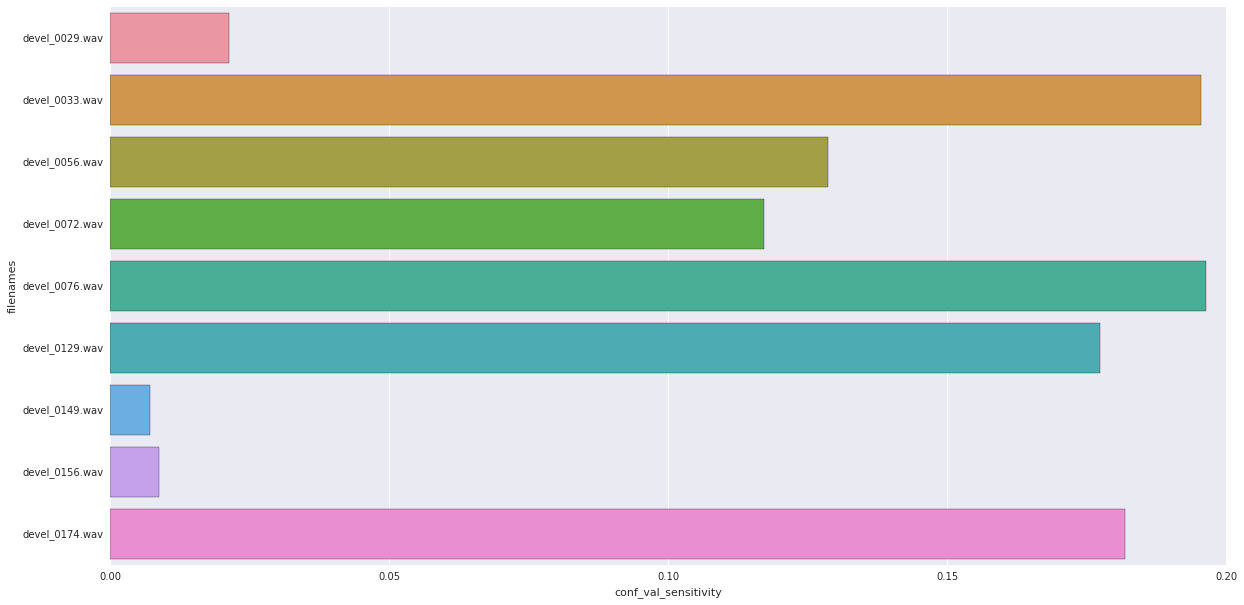

devel_0029.wav 1 1
devel_0033.wav 0 1
devel_0056.wav 1 1
devel_0072.wav 1 1
devel_0076.wav 1 1
devel_0129.wav 0 1
devel_0149.wav 0 1
devel_0156.wav 0 1
devel_0174.wav 0 1


In [51]:
plt.figure(figsize=(20,10))
mask = dfVal['conf_'+metric]<=confidence_thresh
sns.barplot(x=dfVal['conf_'+metric][mask],y=dfVal.filenames[mask])
plt.show()
for names in zip(dfVal.filenames[mask],dfVal.true[mask],dfVal.quality[mask]):
    print("%s %d %d" % names)

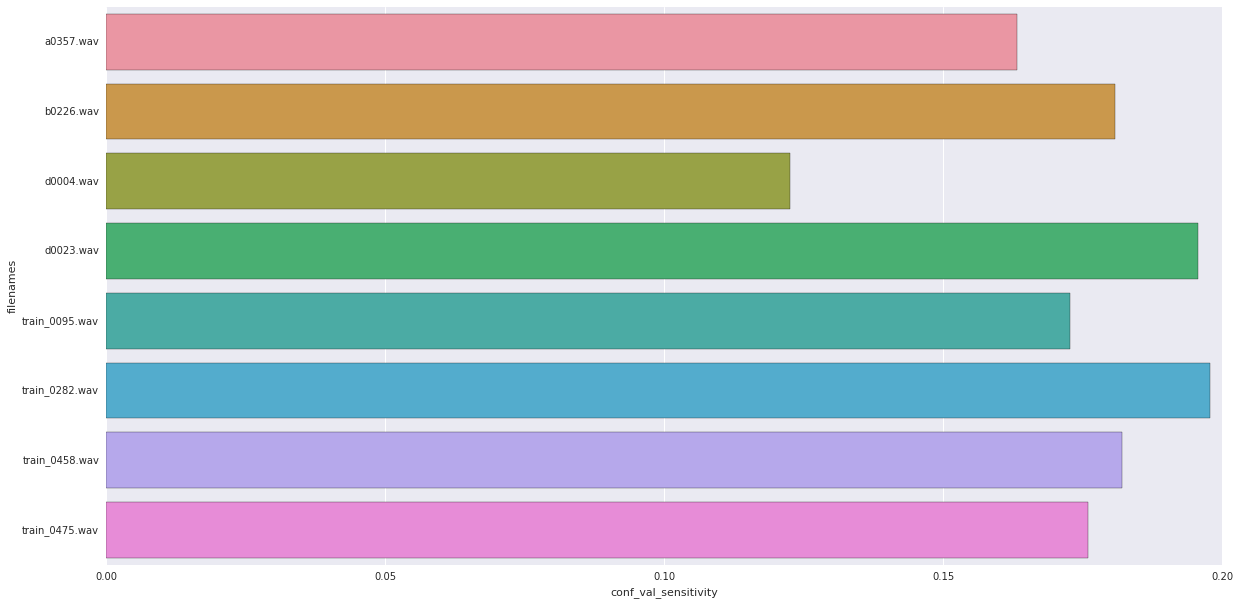

a0357.wav 1 1
b0226.wav 0 0
d0004.wav 1 1
d0023.wav 0 1
train_0095.wav 0 1
train_0282.wav 0 1
train_0458.wav 0 1
train_0475.wav 0 1


In [52]:
plt.figure(figsize=(20,10))
mask = dfTrain['conf_'+metric]<=confidence_thresh
sns.barplot(x=dfTrain['conf_'+metric][mask],y=dfTrain.filenames[mask])
plt.show()
for names in zip(dfTrain.filenames[mask],dfTrain.true[mask],dfTrain.quality[mask]):
    print("%s %d %d" % names)

## Find out the recordings that have huge fluctuations in confidence

In [47]:
for epoch in range(min_epoch,df.epoch.count()):
    checkpoint_name = os.path.join(model_dir+log_name,
                                   "weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch]))
    model.load_weights(checkpoint_name)
    y_pred = model.predict(x_train, verbose=1)
    y_pred_hard = np.argmax(y_pred,axis=-1)
    predicted_confidence = np.asarray([y_pred[i,j] for i,j in zip(range(len(y_pred)),np.nditer(y_train_cc))])
    start_idx=0
    pred = []
    for s in train_parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
        temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
        pred.append(temp)
        start_idx = start_idx + int(s)
    dfTrain["weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch])]=pred

93942/93942 [==============================] - 9s 95us/step


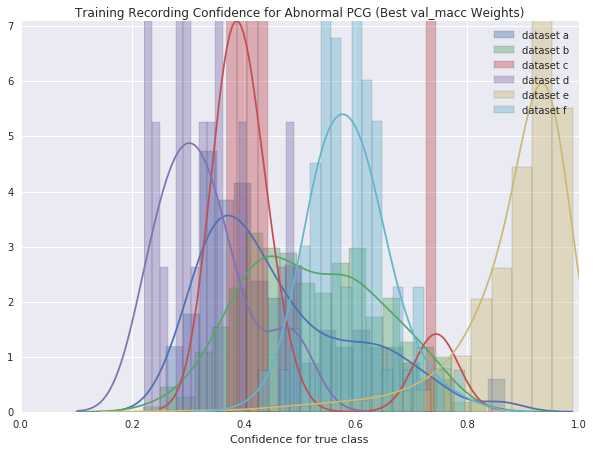

In [398]:
# list_sweep = dfTrain.columns[-(df.epoch.count()-min_epoch):] # list of columns for sweep
# plt.figure(figsize=(20,10))
# sns.boxplot(x="filenames",data=dfTrain[list_sweep.append("filenames")])
# plt.show()
# dfTrain['conf_mean'] = dfTrain[list(dfTrain.columns.values)[-100:]].mean(axis=1).values
# dfTrain['conf_var'] = dfTrain[list(dfTrain.columns.values)[-100:]].var(axis=1).values
metric = 'val_macc'
plt.figure(figsize=(10,7))
for color,dataset in enumerate(dfTrain.dataset.unique()):
    if dataset == 'x':
        continue
#     sns.distplot(dfTrain['conf_'+metric][dfTrain.true == 1][dfTrain.dataset == dataset],bins=20,kde_kws={'bw':.04},label='Abnormal')
    sns.distplot(dfTrain['conf_'+metric][dfTrain.true == 0][dfTrain.dataset == dataset],bins=20,
                 kde_kws={'bw':.04},label='dataset '+dataset,
                )
plt.legend()
plt.xlim([0,1])
plt.xlabel("Confidence for true class")
plt.title("Training Recording Confidence for Abnormal PCG (Best "+metric+" Weights)")
# plt.yscale('log')
plt.show()

In [359]:
for model in dfTrain.columns[4:8].values:
    for true in dfTrain.true.unique():
            print(sum(dfVal[model][dfVal.true == true]<.5))
        

312
203
312
203
312
203
312
203


In [363]:
dfVal[dfVal.true ==1].count()

filenames                   312
dataset                     312
true                        312
quality                     312
conf_val_sensitivity        312
conf_val_macc               312
conf_val_acc                312
conf_val_specificity        312
weights.0101-0.8386.hdf5    312
weights.0102-0.7961.hdf5    312
weights.0103-0.7923.hdf5    312
weights.0104-0.7887.hdf5    312
weights.0105-0.8208.hdf5    312
weights.0106-0.8103.hdf5    312
weights.0107-0.7962.hdf5    312
weights.0108-0.7925.hdf5    312
weights.0109-0.7946.hdf5    312
weights.0110-0.8262.hdf5    312
weights.0111-0.8172.hdf5    312
weights.0112-0.8290.hdf5    312
weights.0113-0.8270.hdf5    312
weights.0114-0.8072.hdf5    312
weights.0115-0.7886.hdf5    312
weights.0116-0.8067.hdf5    312
weights.0117-0.8098.hdf5    312
weights.0118-0.8214.hdf5    312
weights.0119-0.8339.hdf5    312
weights.0120-0.8271.hdf5    312
weights.0121-0.8003.hdf5    312
weights.0122-0.8070.hdf5    312
                           ... 
weights.

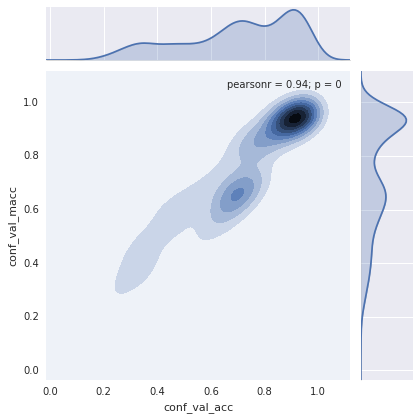

In [320]:
sns.jointplot(x=dfTrain['conf_val_acc'], y=dfTrain['conf_val_macc'], kind="kde")
plt.show()

# Visualize confidence distributions accross recordings

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Number of recordings 12


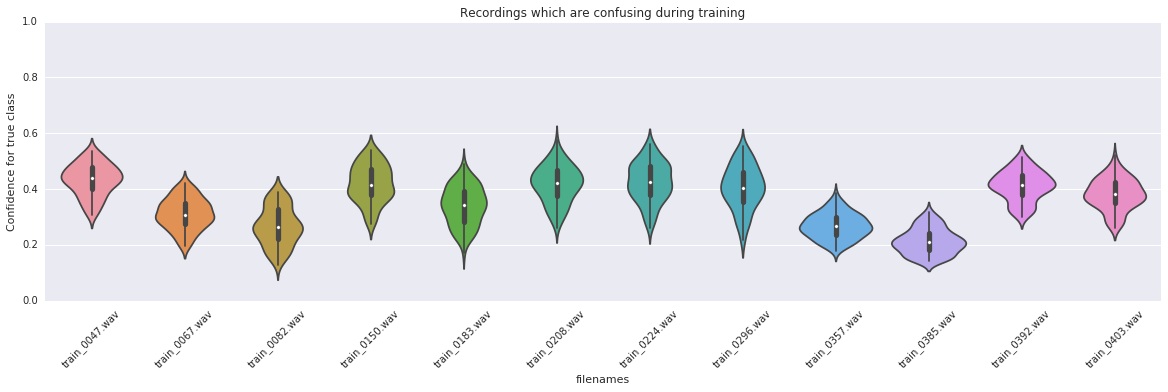

train_0047.wav
train_0067.wav
train_0082.wav
train_0150.wav
train_0183.wav
train_0208.wav
train_0224.wav
train_0296.wav
train_0357.wav
train_0385.wav
train_0392.wav
train_0403.wav


In [121]:
test = dfTrain[dfTrain.conf_mean < .45][dfTrain.true == 1][dfTrain.dataset == 'x']
print("Number of recordings %d" % (test.count()[0]))
test.set_index("filenames",inplace=True)
test = test.transpose()
test = test.iloc[6:-2]
test.set_index(np.r_[0:test.count()[0]],inplace=True)
plt.figure(figsize=(20,5))
sns.violinplot(data=test,jitter=True)
plt.ylabel("Confidence for true class")
plt.title("Recordings which are confusing during training")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()
for names in test.columns.values:
    print("%s" % names)

In [183]:
for dataset in dfTrain.dataset.unique():
    for true in dfTrain.true.unique():
        test = dfTrain[dfTrain.conf_mean > .55][dfTrain.true == true][dfTrain.dataset == dataset].count()[0]
        print("%d" % (test))

170
24
17
83
17
1
12
0
109
1699
3
55
381
2


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


## Validation set inspection

In [78]:
for epoch in range(min_epoch,df.epoch.count()):
    checkpoint_name = os.path.join(model_dir+log_name,
                                   "weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch]))
    model.load_weights(checkpoint_name)
    y_pred = model.predict(x_val, verbose=1)
    y_pred_hard = np.argmax(y_pred,axis=-1)
    predicted_confidence = np.asarray([y_pred[i,j] for i,j in enumerate(y_val_cc)])
    start_idx=0
    pred = []
    for s in val_parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
        temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
        pred.append(temp)
        start_idx = start_idx + int(s)
    dfVal["weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch])]=pred

15511/15511 [==============================] - 1s 94us/step


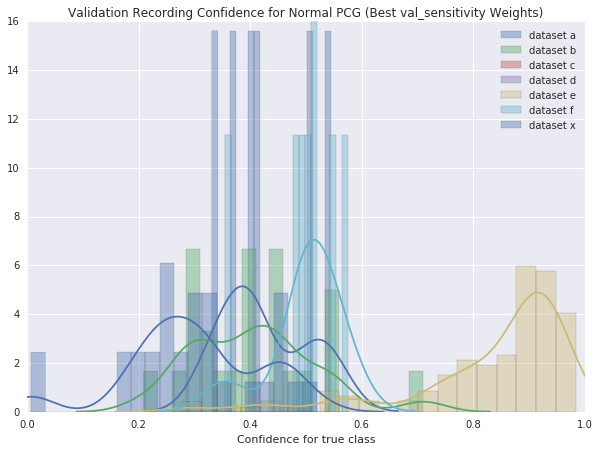

In [305]:
# dfVal['conf_mean'] = dfVal[list(dfVal.columns.values)[-100:]].mean(axis=1).values
# dfVal['conf_var'] = dfVal[list(dfVal.columns.values)[-100:]].var(axis=1).values
plt.figure(figsize=(10,7))
metric = 'val_sensitivity'
for dataset in dfTrain.dataset.unique():
#     sns.distplot(dfVal['conf_'+metric][dfVal.true == 1],bins=20,kde_kws={'bw':.04},label='Abnormal')
    sns.distplot(dfVal['conf_'+metric][dfVal.true == 0][dfVal.dataset == dataset],bins=20,kde_kws={'bw':.04},label='dataset '+dataset)
plt.legend()
plt.xlim([0,1])
plt.xlabel("Confidence for true class")
plt.title("Validation Recording Confidence for Normal PCG (Best "+metric+" Weights)")
plt.show()

In [ ]:
dfTrain.to_csv('/media/taufiq/Data1/heart_sound/dfTrain.csv',index=None)
dfVal.to_csv('/media/taufiq/Data1/heart_sound/dfVal.csv',index=None)